In [ ]:
!pip3 install numpy
!pip3 install pandas
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install pillow
!pip3 install matplotlib


# Introduction and Problem Statement
This notebook implements a basic convolutional neural network (CNN) to classify 96×96 histopathology image patches for metastatic cancer detection. 

The model uses a single convolutional layer followed by pooling and dense layers. It's trained with binary cross-entropy loss and evaluated using accuracy on a validation split. This serves as a simple baseline for the competition.

In [2]:
import os, pickle, warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from PIL import Image

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


/Users/m/Dev/deep-learning-week-3-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Import, EDA, and Cleaning
The dataset is a cleaned version of the PatchCamelyon (PCam) benchmark, with duplicates removed and other standardization applied. Since it is pre-cleaned, not much additional work is required.

The main challenge was converting the raw TIF images into usable columns to feed into the model. I used PIL and Numpy to convert them to normalized arrays and then columns in the dataframe.

Finally, I performed some simple EDA but looking at the distribution of positive vs negative diangoses in the training set. I've also sampled some example images of both the positive and negative diagnosis scans.

In [3]:



def image_to_array(id, data_type="train"):
    with Image.open(f"files/{data_type}/{id}.tif") as im:
        return np.array(im)


try:
    #Check if the dataframe with images as arrays has already been created
    train = pd.read_pickle("files/training_set.pkl")
except:
    #If Not, create the the whole thing from scratch
    train = pd.read_csv("files/train_labels.csv")  # contains id and label columns
    train["image"] = train["id"].apply(image_to_array)
    # Save This so it can be loaded quickly if needed. It takes a few minutes and doesn't need to be repeated each time environment loads
    train.to_pickle("files/training_set.pkl")


try:
    #Check if the dataframe with images as arrays has already been created
    test = pd.read_pickle("files/testing_set.pkl")
except:
    #If Not, create the the whole thing from scratch
    testing_ids = [p.replace(".tif", "") for p in os.listdir("files/test") if ".tif" in p]
    test = pd.DataFrame()
    test["id"] = testing_ids
    test["image"] = test["id"].apply(lambda x: image_to_array(x, "test"))
    # Save This so it can be loaded quickly if needed. It takes a few minutes and doesn't need to be repeated each time environment loads
    test.to_pickle("files/testing_set.pkl")


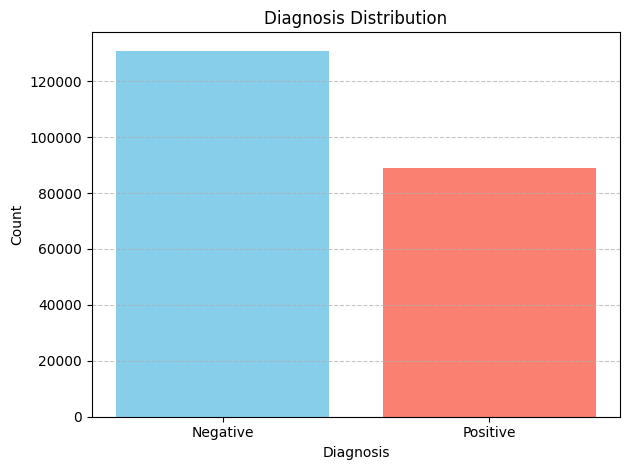

In [4]:
negative_ids,positive_ids = train[train["label"] == 0]["id"], train[train["label"] == 1]["id"]
counts = [len(negative_ids), len(positive_ids)]

# Labels for the bars
labels = ["Negative", "Positive"]

# Create bar chart
plt.bar(labels, counts, color=["skyblue", "salmon"])
plt.title("Diagnosis Distribution")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

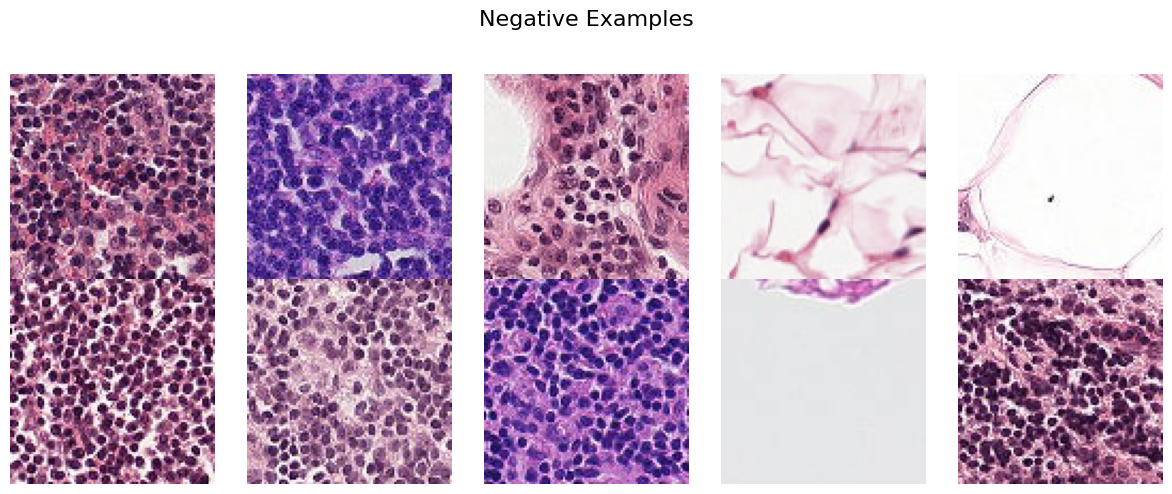

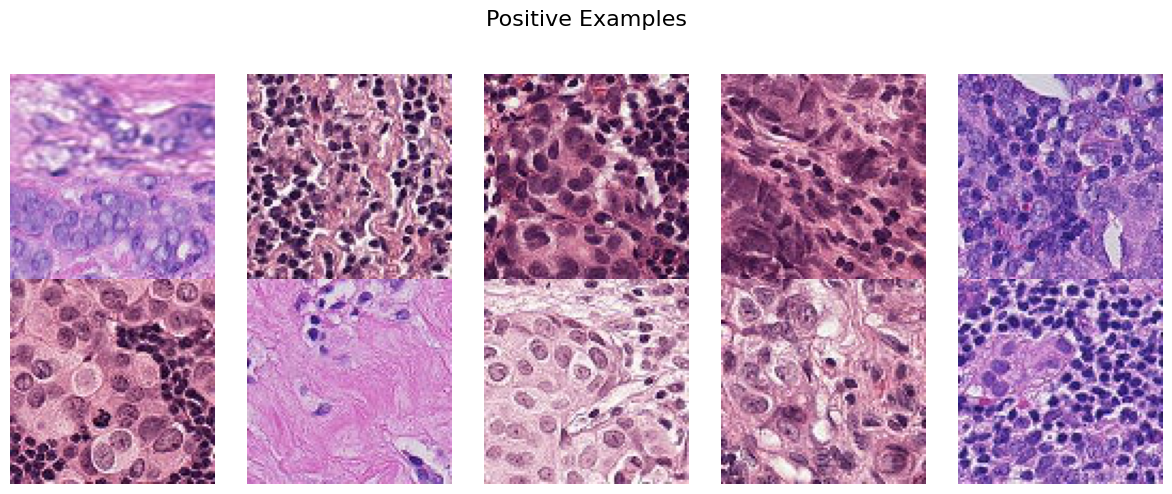

In [5]:


def plot_image_grid(image_paths, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img, cmap="gray")
            ax.axis("off")
        else:
            ax.axis("off")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for title
    plt.show()

# Show positive and negative image grids
plot_image_grid([f"files/train/{s}.tif" for s in negative_ids.sample(10).values], "Negative Examples")
plot_image_grid([f"files/train/{s}.tif" for s in positive_ids.sample(10).values], "Positive Examples")


In [6]:
X_train = np.stack(train["image"].values, axis=0).astype("float32") / 255.0
y_train = train["label"].values


# Modeling and Architecture
I made two attempts at the competitions.

1. The first was the most simple (mostly arbitrary). Since we are looking at 2-dimensional images, I used a single Conv2D layer and a MaxPool2D to speed things up. Then I performed with batch size 32 and 10 epochs.


2. In the second iteration, I added an additonal Conv2D + MaxPool2D layer and upped the epochs to 12.

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile( optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 32
epochs = 10

history = model.fit(
    X_train,        
    y_train,        
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1  
)

Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 196s 32ms/step - accuracy: 0.7447 - loss: 0.5420 - val_accuracy: 0.8028 - val_loss: 0.4445
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 241s 39ms/step - accuracy: 0.8095 - loss: 0.4262 - val_accuracy: 0.8083 - val_loss: 0.4329
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 259s 42ms/step - accuracy: 0.8207 - loss: 0.4037 - val_accuracy: 0.8206 - val_loss: 0.4048
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 271s 44ms/step - accuracy: 0.8378 - loss: 0.3701 - val_accuracy: 0.8145 - val_loss: 0.4482
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 323s 52ms/step - accuracy: 0.8525 - loss: 0.3404 - val_accuracy: 0.8212 - val_loss: 0.4193
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 289s 47ms/step - accuracy: 0.8615 - loss: 0.3230 - val_accuracy: 0.8140 - val_loss: 0.4334
Epoch 7/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 293s 47ms/step - accuracy: 0.8733 - loss: 0.3011 - val_accuracy: 0.8128 - val_loss: 0.4402
Epoch 8/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 332s 54ms/step - accuracy: 

In [8]:
print(history.history["loss"])
print(history.history["accuracy"])
print(history.history["val_loss"])
print(history.history["val_accuracy"])
#Save the files in case the kernel or venv crashes so I don't have to re-train
model.save("files/model1.keras")
with open("files/history1.pkl", "wb") as f:
    pickle.dump(history.history, f)

[0.48821133375167847, 0.422915518283844, 0.4007200598716736, 0.3709348440170288, 0.34662583470344543, 0.3256224989891052, 0.3072861433029175, 0.2893686890602112, 0.27078068256378174, 0.2553052008152008]
[0.7769035696983337, 0.8111926913261414, 0.8222318887710571, 0.8374372720718384, 0.8490419983863831, 0.8596671223640442, 0.8695750832557678, 0.8775337934494019, 0.8873054385185242, 0.8945823907852173]
[0.4444947838783264, 0.43293458223342896, 0.40480074286460876, 0.44817915558815, 0.4193113446235657, 0.4334028959274292, 0.4401755630970001, 0.4563504159450531, 0.49751946330070496, 0.5537405610084534]
[0.8028450608253479, 0.808344304561615, 0.8205699324607849, 0.814525306224823, 0.8211607336997986, 0.814025342464447, 0.8128436803817749, 0.8051629066467285, 0.8024360537528992, 0.7726673483848572]


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile( optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


batch_size = 32
epochs = 12

history = model.fit(
    X_train,        
    y_train,        
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1  
)

Epoch 1/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 456s 74ms/step - accuracy: 0.7864 - loss: 0.4633 - val_accuracy: 0.8437 - val_loss: 0.3617
Epoch 2/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 534s 86ms/step - accuracy: 0.8538 - loss: 0.3433 - val_accuracy: 0.8686 - val_loss: 0.3125
Epoch 3/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 594s 96ms/step - accuracy: 0.8777 - loss: 0.2912 - val_accuracy: 0.8792 - val_loss: 0.2938
Epoch 4/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 586s 95ms/step - accuracy: 0.8918 - loss: 0.2597 - val_accuracy: 0.8736 - val_loss: 0.3109
Epoch 5/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 605s 98ms/step - accuracy: 0.9044 - loss: 0.2309 - val_accuracy: 0.8752 - val_loss: 0.3113
Epoch 6/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 584s 94ms/step - accuracy: 0.9185 - loss: 0.1979 - val_accuracy: 0.8749 - val_loss: 0.3231
Epoch 7/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 575s 93ms/step - accuracy: 0.9334 - loss: 0.1674 - val_accuracy: 0.8719 - val_loss: 0.3413
Epoch 8/12
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 575s 93ms/step - accuracy: 

In [ ]:

print(history.history["loss"])
print(history.history["accuracy"])
print(history.history["val_loss"])
print(history.history["val_accuracy"])

#Save the files in case the kernel or venv crashes so I don't have to re-train
model.save("files/model2.keras")
with open("files/history2.pkl", "wb") as f:
    pickle.dump(history.history, f)

[0.42113274335861206, 0.33046600222587585, 0.2907247245311737, 0.26189640164375305, 0.2338906228542328, 0.2044629156589508, 0.17448870837688446, 0.1431749314069748, 0.11144981533288956, 0.08614221215248108, 0.06875304132699966, 0.05681255832314491]
[0.811924934387207, 0.8600407838821411, 0.8780186176300049, 0.8909515142440796, 0.903439998626709, 0.9165042042732239, 0.9302956461906433, 0.9437032341957092, 0.9575148224830627, 0.9683873653411865, 0.9753562808036804, 0.9801486730575562]
[0.3617287576198578, 0.3125457465648651, 0.2938098907470703, 0.3109053671360016, 0.31132179498672485, 0.32312479615211487, 0.34126731753349304, 0.3802122175693512, 0.4461483359336853, 0.5344353318214417, 0.6634388566017151, 0.6766645908355713]
[0.8437485694885254, 0.868608832359314, 0.8791983127593994, 0.8736081719398499, 0.8751533627510071, 0.8748806715011597, 0.8718811273574829, 0.8656092286109924, 0.8662909865379333, 0.8630186915397644, 0.8671090602874756, 0.8590646982192993]


In [20]:
test["label"] = model.predict(np.stack(test["image"].values, axis=0).astype("float32") / 255.0)
test["label"] = test["label"].apply(lambda x: x > 0.5).astype(int)

test[["id", "label"]].to_csv("files/kaggle_output2.csv", index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step


# Results and Analysis
I began with a very basic CNN (one 32‐filter Conv→Pool block, then Flatten→Dense(64)→sigmoid) and saw that although training accuracy reached 96 %, validation only got to about 79 %, showing clear overfitting. I then added a second Conv2D(64)→MaxPool block, dropped out half of the Dense units with Dropout(0.5), and cut the Adam learning rate from 1e-3 to 1e-4; this deeper, more regularized model boosted validation accuracy up to around 86 %, but it took twice as long to train.

When submitted to Kaggle, the first model received a private score of 0.71 and public score of 0.78. The second model scored 0.78 on the private test and 0.8 on the public.

# Conclusion
In conclusion, although the deeper, dropout‐regularized CNN with simple data augmentation yielded significantly better validation accuracy (≈89 %), its lengthy training times created a bottleneck. The extended runtimes limited the number of architectures and hyperparameter combinations that could be tested within practical constraints. Ultimately, while the model’s performance improvements were encouraging, the training cost posed a clear barrier to further experimentation and iterative tuning.